http://karpathy.github.io/2015/05/21/rnn-effectiveness/

In [26]:
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [4]:
# class RNN:
#     def step(self, x):
#         #update the hidden state
#         self.h = np.tanh()

data = open('input.txt', 'r').read()
# print data


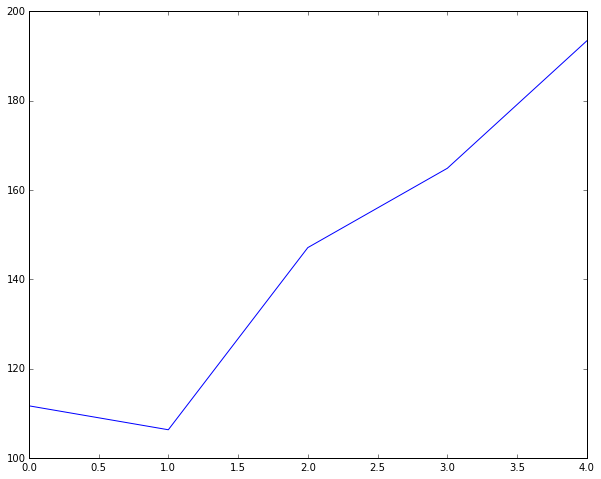

In [71]:

# rand = np.random.RandomState(12)
np.random.seed(32)

hidden_size = 100
seq_length = 25
p = 0
# data = "hello"
data = open('input.txt', 'r').read()
chars = list(set(data))
vocab_size = len(chars)
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
inputs  = [char_to_ix[ch] for ch in data[p     : p + seq_length ]]
targets = [char_to_ix[ch] for ch in data[p + 1 : p + seq_length + 1]]
Wxh = np.random.randn(hidden_size, vocab_size)  * 0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size) * 0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)  * 0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size , 1)) # output bias
hprev = np.zeros((hidden_size,1))

learning_rate = 1e-1
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by)

def lossFun(inputs, targets, hprev):
# def lossFun(inputs, hprev):
    """
    inputs, targes are both list of integers.
    hprev is Hx1 array of initial state
    returns the loss, gradients on model parameters, and last hidden state
    """
    xs, hs, ys, ps = {}, {}, {}, {}
#     hs[-1] = np.copy(hprev)
    loss = 0
    hs[-1] = np.copy(hprev)
    
    # forward pass
    for t in xrange(len(inputs)):
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        dot_x = np.dot(Wxh, xs[t])
        dot_h_prev = np.dot(Whh, hs[t-1])
        hs[t] = np.tanh(dot_x + dot_h_prev + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilites for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
        l = -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
        loss += l
    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(xrange(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1  # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)

    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

def sample(h, seed_ix, n):
    """
    sample a sequence of integers from the model
    h is memory state, seed_ix is seed letter for first time step
    """
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in xrange(n):
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y = np.dot(Why, h) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes


losses = []
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
for i in range(5):

    if p+seq_length+1 >= len(data) or i == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    
    p += seq_length # move data pointer

    mWxh += dWxh * dWxh
    mWhh += dWhh * dWhh
    mWhy += dWhy * dWhy
    mbh += dbh * dbh
    mby += dby * dby
    

    Wxh += -learning_rate * dWxh / np.sqrt(mWxh + 1e-8) # adagrad update
    Whh += -learning_rate * dWhh / np.sqrt(mWhh + 1e-8)
    Why += -learning_rate * dWhy / np.sqrt(mWhy + 1e-8)
    bh += -learning_rate * dbh / np.sqrt(mbh + 1e-8)
    by += -learning_rate * dby / np.sqrt(mby + 1e-8)


    if i % 100 == 0:
#         print inputs
        sample_ix = sample(hprev, inputs[0], 200)
#         txt = ''.join(ix_to_char[ix] for ix in sample_ix)
#         print '-----\n %s \n------' % (txt,)
#         print 'loss', loss
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
#     if i % 100 == 0: print 'iter %d, loss: %f' % (i, smooth_loss) # print progress
    losses.append(loss)

plt.plot(losses)


In [74]:
p = 0
inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]
hprev = np.zeros((hidden_size,1))
print inputs
print targets
# print hprev
loss, a, _, _, _, _, _ = lossFun(inputs, targets, hprev)
# print loss
print a

[31, 81, 65, 15, 40, 0, 31, 40, 15, 15, 40, 13, 83, 44, 9, 82, 0, 81, 66, 66, 82, 64, 17, 86, 65]
[81, 65, 15, 40, 0, 31, 40, 15, 15, 40, 13, 83, 44, 9, 82, 0, 81, 66, 66, 82, 64, 17, 86, 65, 82]
[[-0.01287879  0.          0.         ...,  0.          0.         -0.01581844]
 [-0.00474426  0.          0.         ...,  0.          0.          0.00425313]
 [ 0.0178115   0.          0.         ...,  0.          0.          0.00580286]
 ..., 
 [ 0.00044909  0.          0.         ...,  0.          0.          0.00384821]
 [-0.01153658  0.          0.         ...,  0.          0.         -0.003235  ]
 [-0.00535685  0.          0.         ...,  0.          0.          0.00869725]]
